# Outlier removal

### Support Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For make_features_labels
from tools.feature_format import featureFormat

def scatter_plotter(dict_list, rows_columns=(1,1), figsize=(7, 7)):
    """
    Takes a list of dicts and plots each.
    
    dicts should contain the following:
    'array': X, y array to be plotted
    'title': title for the array
    'masks': dicts with
                -'mask': bool index to apply
                -'kwargs': keyword arguments to apply to the mask 
    """
    r = rows_columns[0]
    c = rows_columns[1]
    plt.close('all')
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i, dicty in enumerate(dict_list):
        X = dicty['array'][:,0]
        y = dicty['array'][:,1]
        ax = fig.add_subplot(r, c, i+1)
        for key, mask in dicty['masks'].items():
            idx = mask['array']
            kwargs = mask['kwargs']
            ax.scatter(X[idx],
                       y[idx], 
                       **kwargs)
        
        title = dicty.get('title', '')
        ax.set_title(title)
        ax.legend()
    plt.show()

In [2]:
# Load the dictionary containing financial data and some email features (to_ from_poi)
import pickle
from tools.feature_format import featureFormat, targetFeatureSplit

with open('data/final_project_dataset.pkl', 'rb') as f:
    fin_data = pickle.load(f)

# Remove 'TOTAL' from data
del fin_data['TOTAL']

# Start with all features except: 'email_address'
all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

data = featureFormat(fin_data, all_feature_names, sort_keys=True, keep_keys=True)

In [3]:
keys, labels, features = data[:,0], data[:,1].astype(float), data[:, 2:].astype(float)
keys.shape, labels.shape, features.shape

((144,), (144,), (144, 19))

In [4]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(features)
scores = clf.decision_function(features)

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


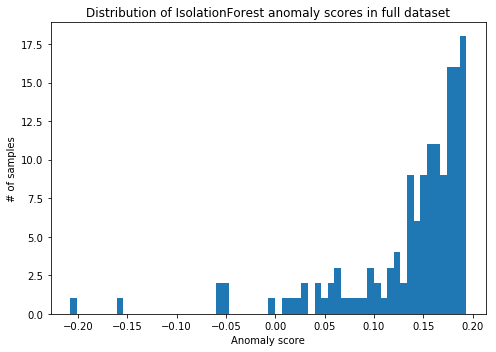

In [5]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
ax = fig.gca()
ax.hist(scores, bins=60)
ax.set_title('Distribution of IsolationForest anomaly scores in full dataset')
ax.set_xlabel('Anomaly score')
ax.set_ylabel('# of samples')
plt.show()

In [6]:
outlier_mask = scores < -0.054
outlier_features, outlier_labels, outlier_keys =\
features[outlier_mask], labels[outlier_mask], keys[outlier_mask]
print 'Number of outliers: ', len(outlier_labels)
print 'Fraction of outliers that are pois: ', float(sum(outlier_labels))/len(outlier_labels)

Number of outliers:  4
Fraction of outliers that are pois:  0.5


In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
arr = pca.fit_transform(features)

plt_dict = {'title': 'outlier removal'}
plt_dict['array'] = arr
plt_dict['masks'] = {}
plt_dict['masks']['poi'] = {'array': (labels == 1),
                            'kwargs': {'facecolors':'none', 
                                       'edgecolors':'b',
                                       'label':'poi'}}
plt_dict['masks']['non_poi'] = {'array': (labels == 0),
                                'kwargs': {'facecolors':'none', 
                                            'edgecolors':'r',
                                            's':5,
                                            'label':'non_poi'}}
plt_dict['masks']['outliers'] = {'array': outlier_mask,
                                 'kwargs': {'color':'k',
                                            'marker':'x',
                                            's':80,
                                            'label':'outliers'}}

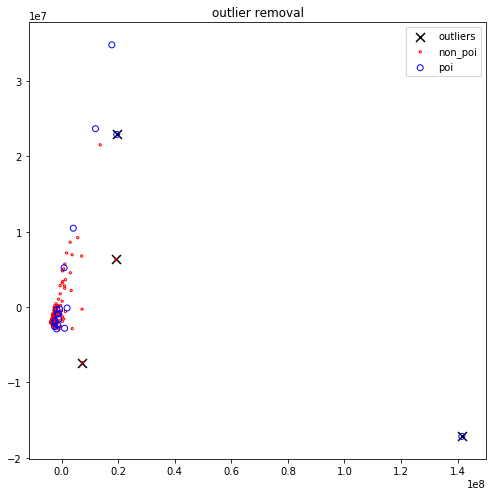

In [8]:
scatter_plotter([plt_dict])

In [9]:
for key in outlier_keys:
    print key

BHATNAGAR SANJAY
FREVERT MARK A
LAY KENNETH L
SKILLING JEFFREY K


In [10]:
out_data = fin_data.copy()
for key in outlier_keys:
    del out_data[key]

with open('out_data.pkl', 'wb') as f:
    pickle.dump(out_data, f)